# ZClassifier

Comparison between two model's implicit covariance matrices from explicit normal random vectors.

Result: Statisticaly same because both model pretrained on the CIFAR-10 dataset.

## Overall train & test

In [ ]:
import google.colab.drive as drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir("/content/drive/MyDrive/Colab Notebooks/Self_Study/ZClassifier")

In [ ]:
from models import ZClassifier, SoftmaxClassifier, ResNetFeature, VGGFeature
from models import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 train set for training
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(cifar10, batch_size=100, shuffle=True)


# Load CIFAR-10 test set for analysis
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
eval_loader = DataLoader(cifar10, batch_size=100, shuffle=False)


In [ ]:
class Trainer:
    def __init__(self, modelA, modelB, train_loader, eval_loader, optimizerA, optimizerB, criterion, device):
        self.modelA = modelA
        self.modelB = modelB
        self.train_loader = train_loader
        self.eval_loader = eval_loader
        self.optimizerA = optimizerA
        self.optimizerB = optimizerB
        self.criterion = criterion
        self.device = device

    def train(self, num_epochs):
        bar = tqdm(range(num_epochs))

        for epoch in bar:
            self.modelA.train()
            self.modelB.train()
            train_lossA = 0
            train_lossB = 0
            # Lists to store predictions and true labels for classification_report
            all_predsA = []
            all_predsB = []
            all_labels = []

            bar2 = tqdm(self.train_loader, leave=False)
            for x, y in bar2:
                x, y = x.to(self.device), y.to(self.device)
                self.optimizerA.zero_grad()
                self.optimizerB.zero_grad()

                # Use the simplified ZClassifier output z directly
                za = self.modelA(x)
                zb = self.modelB(x)

                # Calculate loss using the updated criterion
                lossA = self.criterion(za, y)
                lossB = self.criterion(zb, y)

                lossA.backward()
                lossB.backward()

                self.optimizerA.step()
                self.optimizerB.step()

                train_lossA += lossA.item() * x.size(0)
                train_lossB += lossB.item() * x.size(0)

                # Store predictions and labels for classification_report
                predictedA = torch.argmax(za.data, 1)
                predictedB = torch.argmax(zb.data, 1)

                all_predsA.extend(predictedA.cpu().numpy())
                all_predsB.extend(predictedB.cpu().numpy())
                all_labels.extend(y.cpu().numpy())


                bar2.set_description(f"Batch LossA: {lossA.item():.4f}, Batch LossB: {lossB.item():.4f}")

            avg_train_lossA = train_lossA / len(self.train_loader.dataset)
            avg_train_lossB = train_lossB / len(self.train_loader.dataset)

            # Calculate and print classification report
            reportA = classification_report(all_labels, all_predsA, output_dict=True)
            reportB = classification_report(all_labels, all_predsB, output_dict=True)

            train_accuracyA = reportA['accuracy']
            train_accuracyB = reportB['accuracy']

            bar.set_description(f"Epoch {epoch+1}/{num_epochs}, Train LossA: {avg_train_lossA:.4f}, Train LossB: {avg_train_lossB:.4f}, Train AccA: {train_accuracyA:.4f}, Train AccB: {train_accuracyB:.4f}")

    def test(self):
        self.modelA.eval()
        self.modelB.eval()
        test_lossA = 0
        test_lossB = 0
        all_predsA = []
        all_predsB = []
        all_labels = []
        all_za = []
        all_zb = []

        with torch.no_grad():
            for x, y in self.eval_loader:
                x, y = x.to(self.device), y.to(self.device)
                za = self.modelA(x)
                zb = self.modelB(x)

                predictedA = torch.argmax(za.data, 1)
                predictedB = torch.argmax(zb.data, 1)

                all_predsA.extend(predictedA.cpu().numpy())
                all_predsB.extend(predictedB.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

                all_za.append(za.cpu())
                all_zb.append(zb.cpu())

        reportA = classification_report(all_labels, all_predsA)
        reportB = classification_report(all_labels, all_predsB)

        print("\nTest Classification Report Model A:")
        print(reportA)
        print("\nTest Classification Report Model B:")
        print(reportB)

        # Pool representations
        all_za = torch.cat(all_za, dim=0).numpy()
        all_zb = torch.cat(all_zb, dim=0).numpy()

        # Covariance and correlation
        cov_za = np.cov(all_za.T)
        cov_zb = np.cov(all_zb.T)
        corr_za = np.corrcoef(all_za.T)
        corr_zb = np.corrcoef(all_zb.T)
        diff_cov = np.abs(cov_za - cov_zb)
        diff_corr = np.abs(corr_za - corr_zb)

        # Bartlett's test (equal variances for each corresponding dimension)
        bartlett_pvals = [bartlett(all_za[:, i], all_zb[:, i]).pvalue for i in range(all_za.shape[1])]

        # Frobenius norm difference
        frob_diff_cov = norm(cov_za - cov_zb, 'fro')
        frob_diff_corr = norm(corr_za - corr_zb, 'fro')

        # PCA projection (2D)
        pca = PCA(n_components=2)
        za_2d = pca.fit_transform(all_za)
        zb_2d = pca.fit_transform(all_zb)

        # Plot all
        fig, axes = plt.subplots(4, 2, figsize=(16, 20))

        sns.heatmap(cov_za, ax=axes[0, 0], cmap='coolwarm')
        axes[0, 0].set_title('Covariance Matrix - Model A')
        sns.heatmap(cov_zb, ax=axes[0, 1], cmap='coolwarm')
        axes[0, 1].set_title('Covariance Matrix - Model B')

        sns.heatmap(corr_za, ax=axes[1, 0], cmap='coolwarm', vmin=-1, vmax=1)
        axes[1, 0].set_title('Correlation Matrix - Model A')
        sns.heatmap(corr_zb, ax=axes[1, 1], cmap='coolwarm', vmin=-1, vmax=1)
        axes[1, 1].set_title('Correlation Matrix - Model B')

        sns.heatmap(diff_cov, ax=axes[2, 0], cmap='YlOrRd')
        axes[2, 0].set_title(f'|Cov A - Cov B| (Frobenius: {frob_diff_cov:.2f})')
        sns.heatmap(diff_corr, ax=axes[2, 1], cmap='YlOrRd', vmin=0, vmax=2)
        axes[2, 1].set_title(f'|Corr A - Corr B| (Frobenius: {frob_diff_corr:.2f})')

        axes[3, 0].scatter(za_2d[:, 0], za_2d[:, 1], alpha=0.5, label='Model A')
        axes[3, 0].scatter(zb_2d[:, 0], zb_2d[:, 1], alpha=0.5, label='Model B')
        axes[3, 0].legend()
        axes[3, 0].set_title('PCA Projection (2D)')

        axes[3, 1].plot(bartlett_pvals)
        axes[3, 1].axhline(0.05, color='red', linestyle='--')
        axes[3, 1].set_title('Bartlett p-values per dimension (α=0.05)')
        axes[3, 1].set_xlabel('Dimension')
        axes[3, 1].set_ylabel('p-value')

        plt.tight_layout()
        plt.show()

In [ ]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelA = ZClassifier(ResNetFeature(), latent_dim=30, beta=1).to(device)
modelB = ZClassifier(VGGFeature(), latent_dim=30, beta=1).to(device)

In [ ]:
# Training settings
num_epochs = 10
optimizerA = torch.optim.Adam(modelA.parameters(), lr=5e-4)
optimizerB = torch.optim.Adam(modelB.parameters(), lr=5e-4)
I = lambda label: F.one_hot(label, num_classes=10).float() # One-hot encoding
criterion = lambda x, y: F.cross_entropy(x, y) + 10 * F.gaussian_nll_loss(x, I(y), var=1.0) # KL divergence

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


Test Classification Report Model A:
              precision    recall  f1-score   support

           0       0.73      0.94      0.82      1000
           1       0.93      0.93      0.93      1000
           2       0.90      0.68      0.78      1000
           3       0.78      0.61      0.69      1000
           4       0.79      0.87      0.83      1000
           5       0.71      0.84      0.77      1000
           6       0.82      0.94      0.88      1000
           7       0.96      0.81      0.88      1000
           8       0.92      0.90      0.91      1000
           9       0.95      0.87      0.91      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000


Test Classification Report Model B:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1000
           1       0.89      0.93      0.91      1000
    

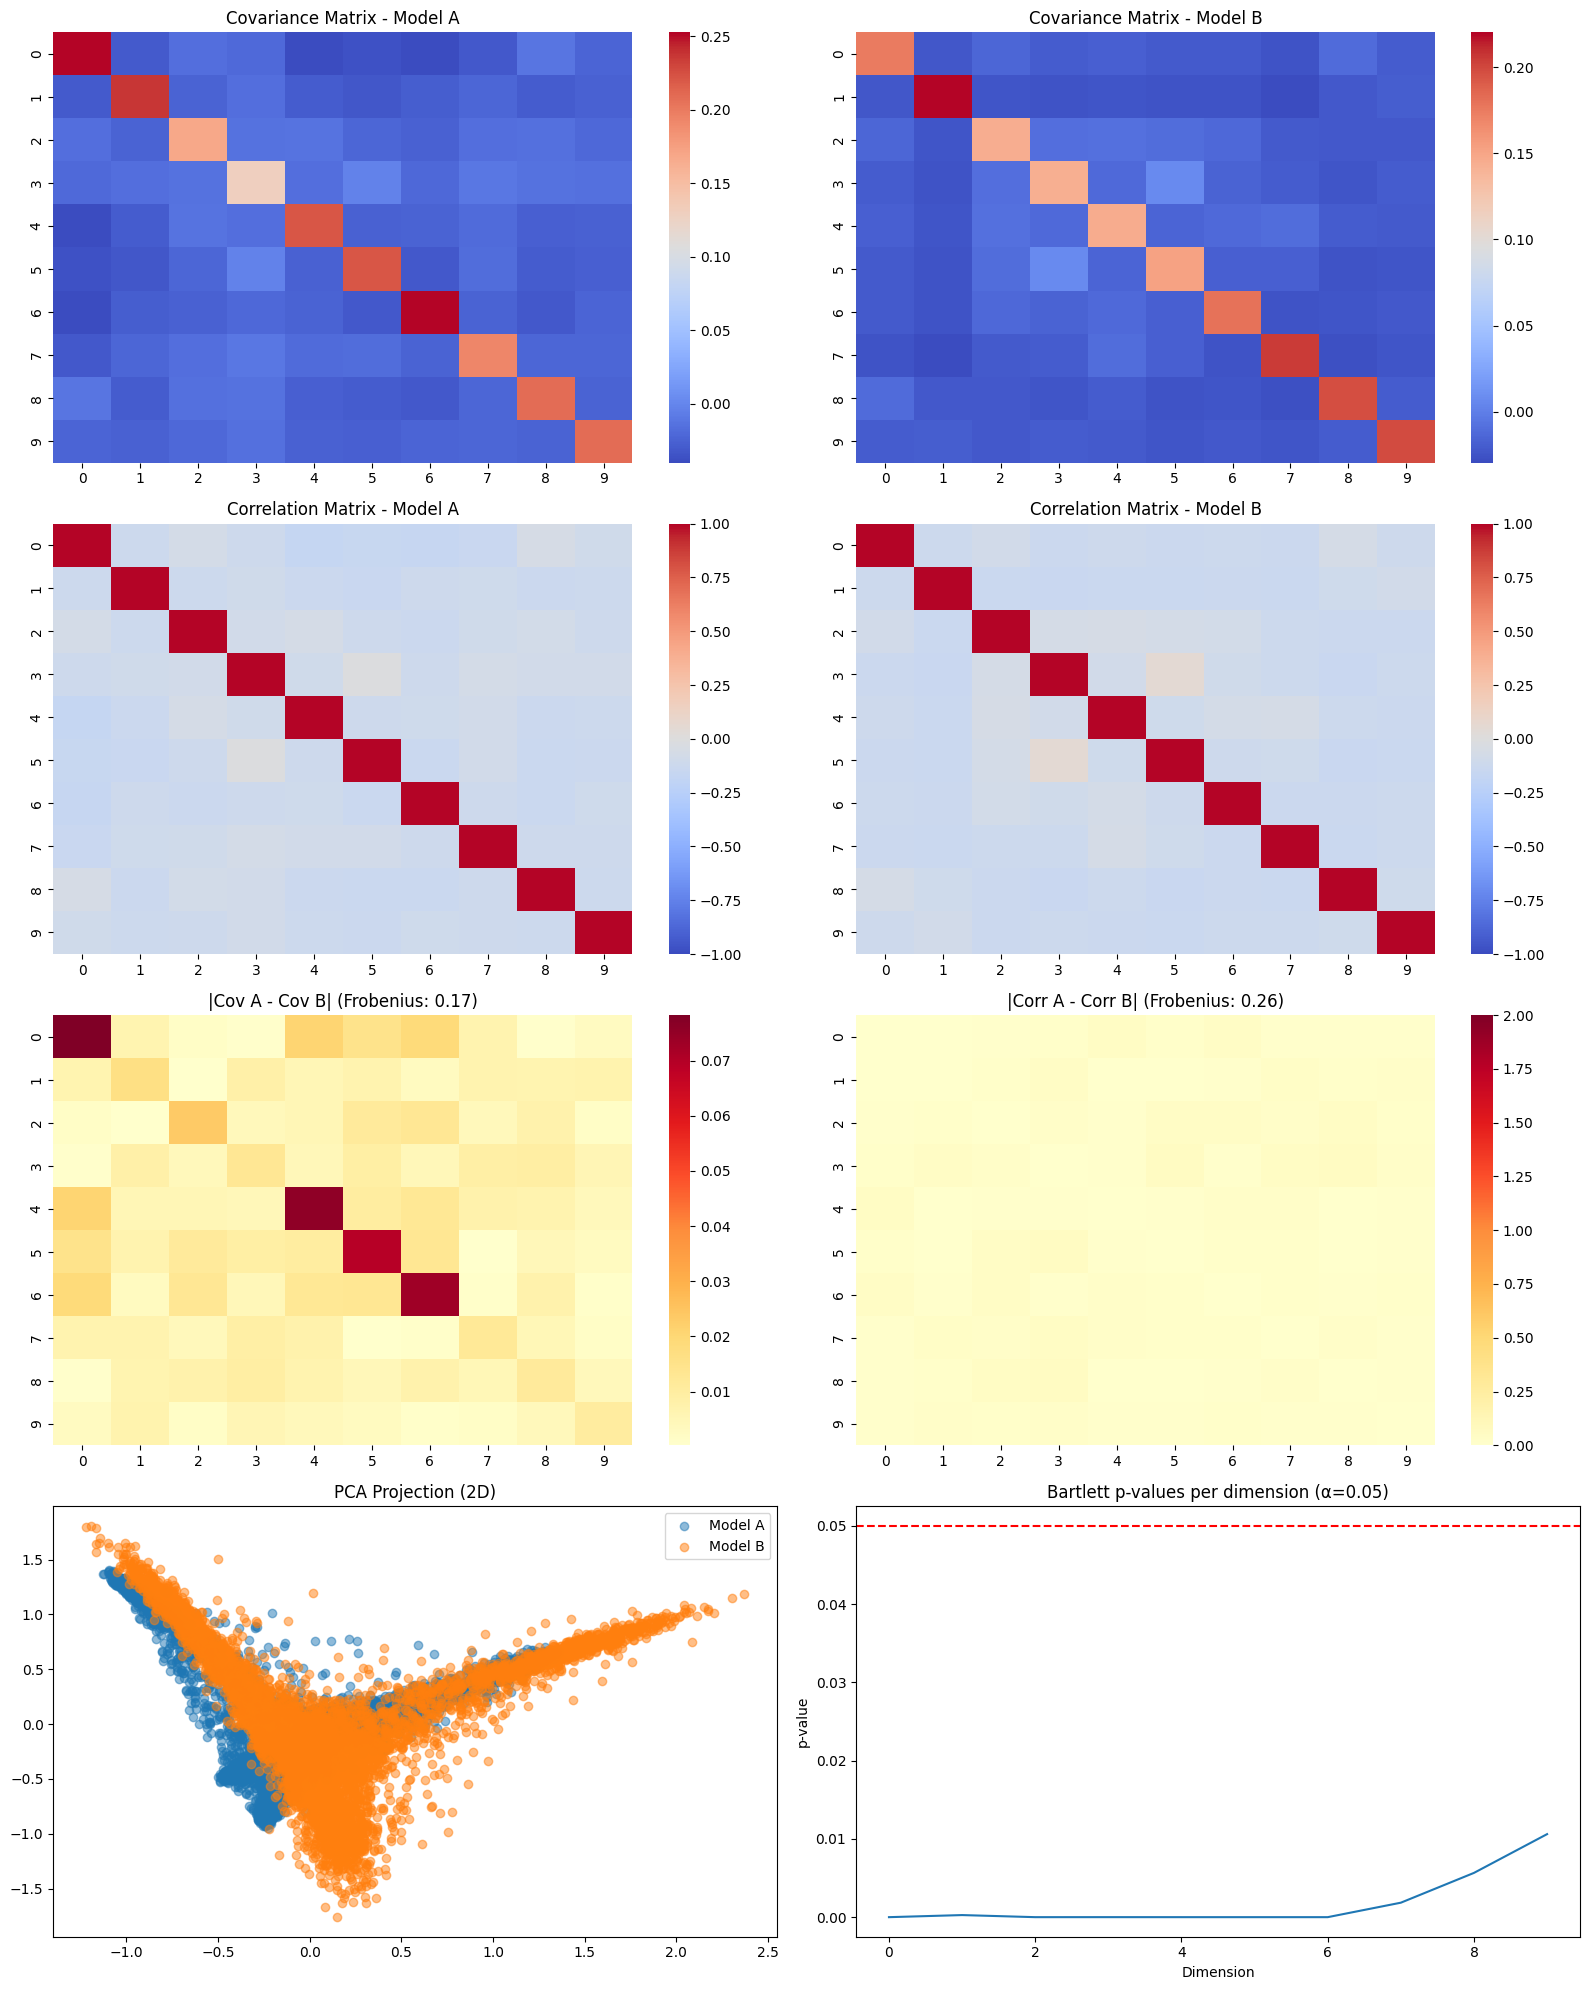

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    modelA=modelA,
    modelB=modelB,
    train_loader=train_loader,
    eval_loader=eval_loader,
    optimizerA=optimizerA,
    optimizerB=optimizerB,
    criterion=criterion,
    device=device
)

# Start training
trainer.train(num_epochs=num_epochs)

# Evaluate after training
trainer.test()

In [ ]:
base_path = "/content/drive/MyDrive/Colab Notebooks/Self_Study/ZClassifier/pretrained"

torch.save(modelA.state_dict(), f'{base_path}/modelA.pth')
torch.save(modelB.state_dict(), f'{base_path}/modelB.pth')

# Baseline models

In [ ]:
# Define a standard CNN classifier (e.g., ResNet18) with softmax output
class SoftmaxClassifier(nn.Module):
    def __init__(self, feature_extractor, num_classes=10):
        super().__init__()
        self.features = feature_extractor
        self.head = nn.Linear(self.features.out_dim, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.head(x)  # Logits (no softmax here; use later for scoring)
        return x

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


Test Classification Report Model A:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1000
           1       0.73      0.98      0.84      1000
           2       0.79      0.79      0.79      1000
           3       0.70      0.68      0.69      1000
           4       0.76      0.86      0.81      1000
           5       0.69      0.83      0.75      1000
           6       0.91      0.82      0.86      1000
           7       0.95      0.78      0.85      1000
           8       0.95      0.86      0.90      1000
           9       0.96      0.72      0.82      1000

    accuracy                           0.81     10000
   macro avg       0.83      0.81      0.82     10000
weighted avg       0.83      0.81      0.82     10000


Test Classification Report Model B:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1000
           1       0.84      0.95      0.89      1000
    

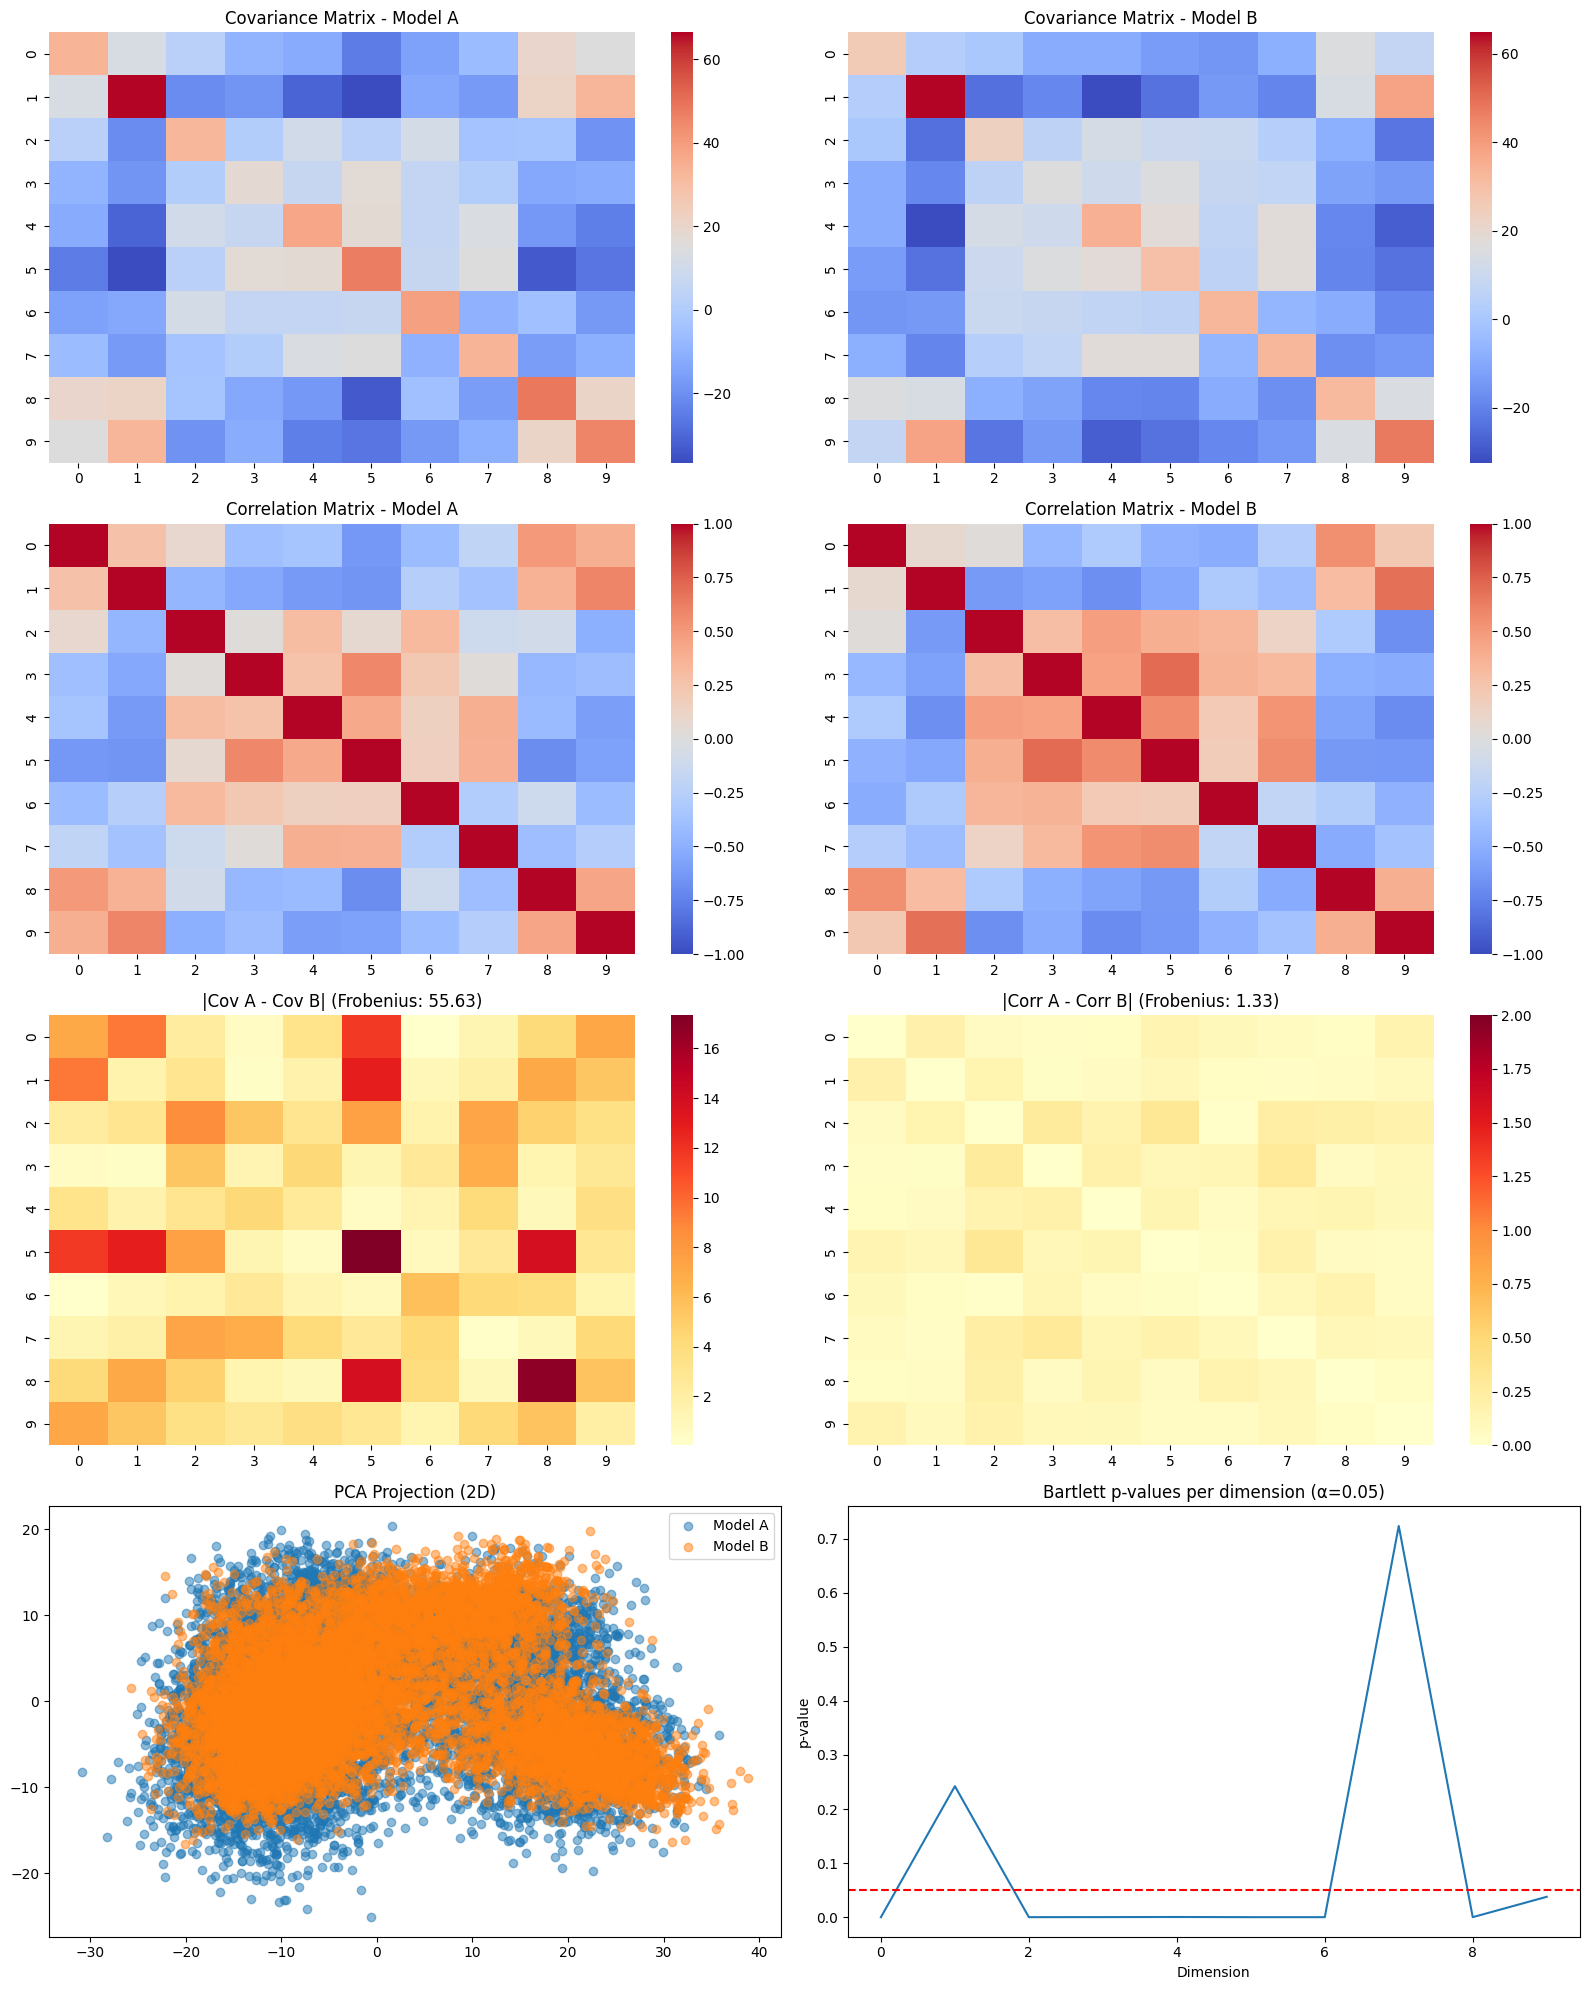

In [ ]:
# Softmax model 정의 (baseline)
softmax_model = SoftmaxClassifier(ResNetFeature()).to(device)
softmax_optimizer = torch.optim.Adam(softmax_model.parameters(), lr=5e-4)
softmax_criterion = nn.CrossEntropyLoss()

# KL term 제거된 ZClassifier (λ=0 ablation)
model_nokl = ZClassifier(ResNetFeature(), latent_dim=30, beta=1).to(device)
optimizer_nokl = torch.optim.Adam(model_nokl.parameters(), lr=5e-4)
criterion_nokl = lambda x, y: F.cross_entropy(x, y)  # KL 없는 버전

# Trainer 통합 구성 (Softmax vs ZClassifier without KL)
ablation_trainer = Trainer(
    modelA=softmax_model,
    modelB=model_nokl,
    train_loader=train_loader,
    eval_loader=eval_loader,
    optimizerA=softmax_optimizer,
    optimizerB=optimizer_nokl,
    criterion=criterion_nokl,  # softmax도 CE이므로 공유해도 무방
    device=device
)

# 학습 및 테스트 수행
ablation_trainer.train(num_epochs=num_epochs)
ablation_trainer.test()

In [ ]:
torch.save(softmax_model.state_dict(), f'{base_path}/softmax_model.pth')
torch.save(model_nokl.state_dict(), f'{base_path}/model_nokl.pth')